In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/transformed_oct.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
# Load ResNet50 model
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Freeze
for layer in base_model.layers[:50]:
     layer.trainable = False

# Set trainable
for layer in base_model.layers[50:]:
     layer.trainable = True

# Add new layers
#x = base_model.get_layer("conv3_block4_out").output
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Define downstream model
downstream_model = Model(inputs=base_model.input, outputs=output)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=2, min_lr=0.000001,verbose=1)

# Compile model for downstream task
downstream_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', 'precision', 'recall', 'auc']
)

In [ ]:
downstream_model.load_weights('/content/drive/MyDrive/weights/Full_Model/downstream_task_weights.weights.h5',skip_mismatch=True)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 314 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#Test Dataset
test_dir = '/content/Downstream Task/test'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
	shuffle=False,
  batch_size=64
)

Found 200 images belonging to 4 classes.


In [ ]:
results = downstream_model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8711 - auc: 0.9739 - loss: 0.3863 - precision: 0.8837 - recall: 0.8680


In [ ]:
num_of_test_samples=5465
batch_size=64
Y_pred = downstream_model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['CNV', 'DME', 'DRUSEN','NORMAL']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Confusion Matrix
[[49  1  0  0]
 [ 3 47  0  0]
 [ 9  3 25 13]
 [ 1  1  3 45]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.79      0.98      0.88        50
         DME       0.90      0.94      0.92        50
      DRUSEN       0.89      0.50      0.64        50
      NORMAL       0.78      0.90      0.83        50

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.82       200
weighted avg       0.84      0.83      0.82       200



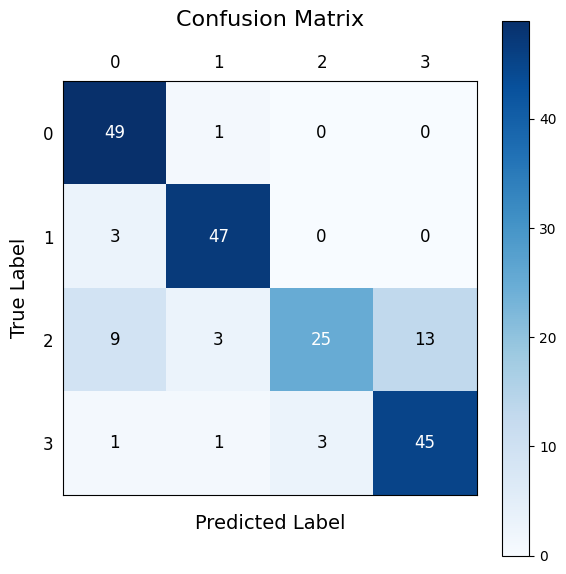

In [ ]:
# Confusion matrix
confmat = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confmat, cmap="Blues")

# Color bar
fig.colorbar(cax)

# Annotate
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', color="black" if confmat[i, j] < confmat.max()/2 else "white", fontsize=12)

# Set labels
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.title('Confusion Matrix', fontsize=16, pad=20)

# Customize ticks
ax.set_xticks(np.arange(confmat.shape[1]))
ax.set_yticks(np.arange(confmat.shape[0]))
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display
plt.tight_layout()
plt.savefig('out.png', dpi=300)
plt.show()


In [ ]:
y_true = test_generator.classes[:86 * test_generator.batch_size]
num_of_test_samples=5465
batch_size=64
y_pred = downstream_model.predict(test_generator, num_of_test_samples // batch_size+1)
auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')
print("AUC Score:", auc_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
AUC Score: 0.9732666666666666


In [ ]:
# assume y_true and y_pred
n_classes = len(np.unique(y_true))

# reshape y_true and y_pred to be 2-dimensional arrays
y_true = y_true.reshape(-1, 1)
y_pred = y_pred.reshape(-1, n_classes)

# compute AUC score for each class
auc_scores = []
for i in range(n_classes):
    auc_scores.append(roc_auc_score(y_true == i, y_pred[:, i]))

# print AUC score for each class
for i in range(n_classes):
    print("AUC score for class {}: {:.3f}".format(i, auc_scores[i]))

AUC score for class 0: 0.990
AUC score for class 1: 0.993
AUC score for class 2: 0.946
AUC score for class 3: 0.964


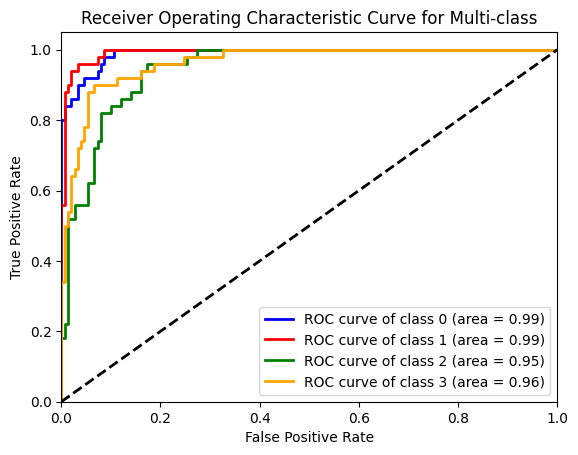

<Figure size 640x480 with 0 Axes>

In [ ]:
# y_true and y_pred
n_classes = len(np.unique(y_true))

# reshape
y_true = y_true.reshape(-1, 1)
y_pred = y_pred.reshape(-1, n_classes)

# ROC curve and area
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig('plot.png', dpi=3000, bbox_inches='tight')

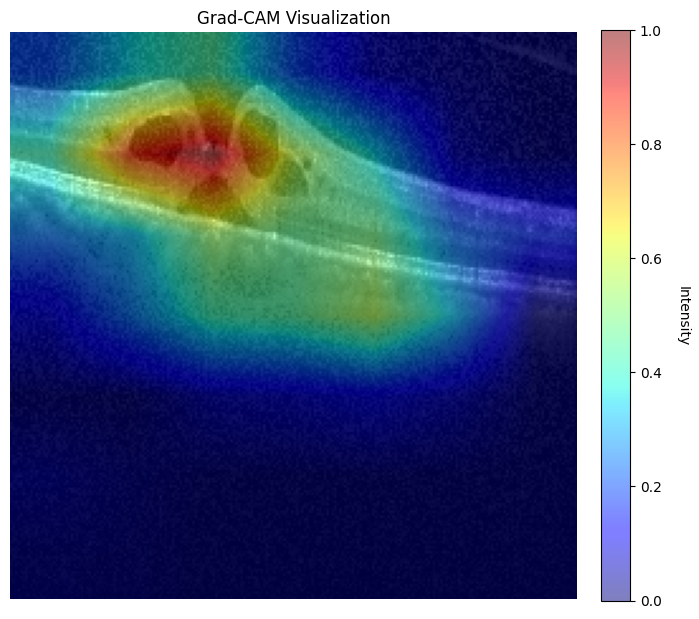

In [ ]:
# Load
img_path = "/content/drive/MyDrive/DME-943690-9.jpeg"  # image path
image = load_img(img_path, target_size=(224, 224))  # size is 224x224
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0  # Normalize

# last convolutional layer
last_conv_layer = downstream_model.get_layer('conv5_block3_out')  # Last layer name

# a model that outputs the last conv layer
grad_model = tf.keras.models.Model(
    [downstream_model.inputs],
    [last_conv_layer.output, downstream_model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image_array)
    predicted_class = tf.argmax(predictions[0])
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# the gradients
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize heatmap
heatmap = tf.image.resize(heatmap[..., np.newaxis], (image.size[1], image.size[0]))
heatmap = heatmap.numpy()
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

plt.figure(figsize=(8, 8))

# Show original
plt.imshow(image)

# Overlay heatmap
heatmap_plot = plt.imshow(heatmap[..., 0], cmap='jet', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(heatmap_plot, fraction=0.046, pad=0.04)
cbar.set_label('Intensity', rotation=270, labelpad=20)

# Finalize the plot
plt.axis('off')
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
# Terminate
import os, signal
os.kill(os.getpid(), signal.SIGKILL)